## Imports & Loading the data

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [2]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]
# Pandas configuration
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [3]:
data_subsets_splitted_joined = pickle.load(open('gc_lagged_data.pickle', 'rb'))
sj_train_train, sj_train_test, iq_train_train, iq_train_test = data_subsets_splitted_joined

In [4]:
wo_feat_eng = pickle.load(open('splitted_joined_data.pickle', 'rb'))
sj_train_train_wof, sj_train_test_wof, iq_train_train_wof, iq_train_test_wof = wo_feat_eng

In [5]:
sj_train_test = sj_train_test.join(sj_train_test_wof[['weekofyear', 
                                                      'year', 
                                                      'week_start_date', 
                                                      'month', 
                                                      'city']])
sj_train_train = sj_train_train.join(sj_train_train_wof[['weekofyear', 
                                                         'year', 
                                                         'week_start_date', 
                                                         'month', 
                                                         'city']])

In [6]:
sj_train_test.dropna(inplace=True)
sj_train_train.dropna(inplace=True)

In [7]:
# function for evaluation of models
def model_classification(actual, predicted): 
    """
    Prints out RSME, MAE and explained variance score
    """
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

## Wisorizing

In [8]:
def winsorizer(df, colname, clip_upper, time_ratio=0.5):
    '''
    Inputs:
    df: dataframe
    colname: name of the variable to be winsorised
    clip_upper: where to clip the values in proportion to the global maximum,
    e.g. 0.8 => clip the values above 80% of the global maximum of the variable
    ratio: what portion of the series should be winsorised, 
    e.g. 0.3 => the first third of the series is modified.
    Output: the dataframe with one modified variable
    '''
    early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
    late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
    clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
    df[colname] = pd.concat([clipped_var, late[colname]])
    return df

In [9]:
sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

## Extracting the seasonality 

In [10]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly_median = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .median(axis=1)
        )
        jan = pd.Series(weekly_median[1])
        jan.index = [len(weekly_median)+1]

        dec = pd.Series(weekly_median[len(weekly_median)])
        dec.index = [weekly_median.index[0]-1]

        weekly_median = weekly_median.append(jan)
        weekly_median = weekly_median.append(dec)

        smooth_seasonality = (
            weekly_median
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [65]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases')
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,33.833333
1,2,30.000000
2,3,30.666667
3,4,33.666667
4,5,29.333333


## Evaluating the saisonality as a baseline model

In [13]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [14]:
seasonality_for_test(sj_train_test, sj_train_train_seas)

0      32.500000
1      33.833333
2      30.000000
3      30.666667
4      33.666667
         ...    
221    11.333333
222    12.000000
223    11.000000
224    10.666667
225     9.666667
Name: total_cases_seas, Length: 226, dtype: float64

In [15]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 27.31
--------------------
MAE: 18.52
Explained variance: 0.117
--------------------


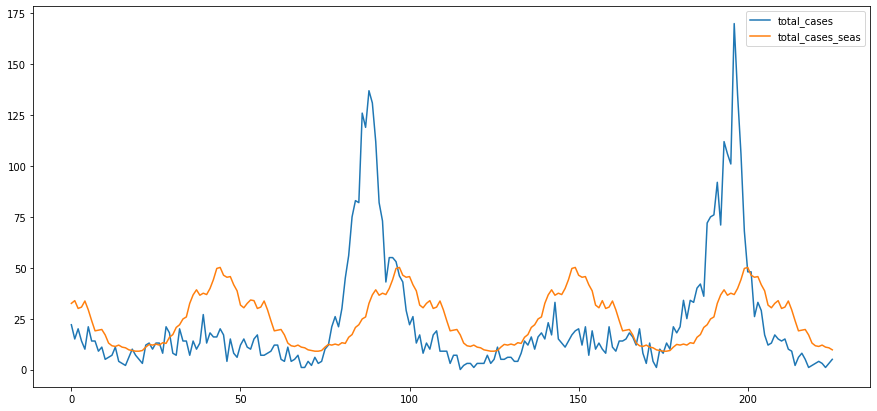

In [16]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

## Substracting the saisonality

In [17]:
def substract_seas(df, cols, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            get_smooth_seasonality_df(df, cols),
            how='left', 
            on='weekofyear',
            suffixes=('','_w_seas')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_w_seas' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_w_seas' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [18]:
# substract_seas(sj_train_train, ['total_cases','reanalysis_sat_precip_amt_mm'], drop=True)

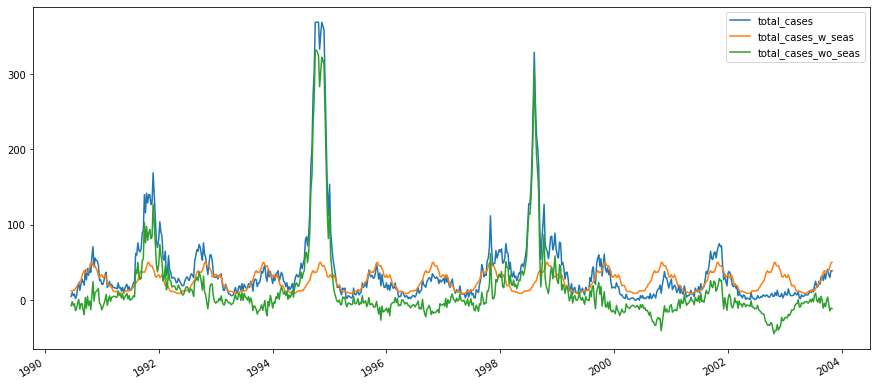

In [19]:
sj_train_train_tc_wo_seas = substract_seas(sj_train_train, 'total_cases')
sj_train_test_tc_wo_seas = substract_seas(sj_train_test, 'total_cases')
(
    sj_train_train_tc_wo_seas
    .loc[:,['total_cases', 'total_cases_w_seas', 'total_cases_wo_seas']]
    .plot()
);

## Regression (Random Forest)

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
sj_cols_seas = sj_train_train.columns.to_list()
unwanted = ['week_start_date',
            'city',
            'year',
            'weekofyear',
            'month']
sj_cols_seas = [e for e in sj_cols_seas if e not in unwanted]
sj_cols_seas

sj_train_train_wo_seas = substract_seas(sj_train_train, sj_cols_seas, drop=True)
sj_train_test_wo_seas = substract_seas(sj_train_test, sj_cols_seas, drop=True)

In [108]:
X_train = (
    sj_train_train_wo_seas
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases_wo_seas'], axis=1)
)
X_test = (
    sj_train_test_wo_seas
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases_wo_seas'], axis=1)
)
y_train = sj_train_train_tc_wo_seas.total_cases_wo_seas
y_test = sj_train_test_tc_wo_seas.total_cases_wo_seas

In [109]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=20,
                           min_samples_split= 5,
                           max_leaf_nodes= 43,
)

In [110]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_leaf_nodes=43, min_samples_split=5)

In [111]:
y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

In [112]:
test_seas_model = seasonality_for_test(sj_train_test, sj_train_train_seas)
test_seas_model.index = y_test.index 
# test_seas_model

<AxesSubplot:>

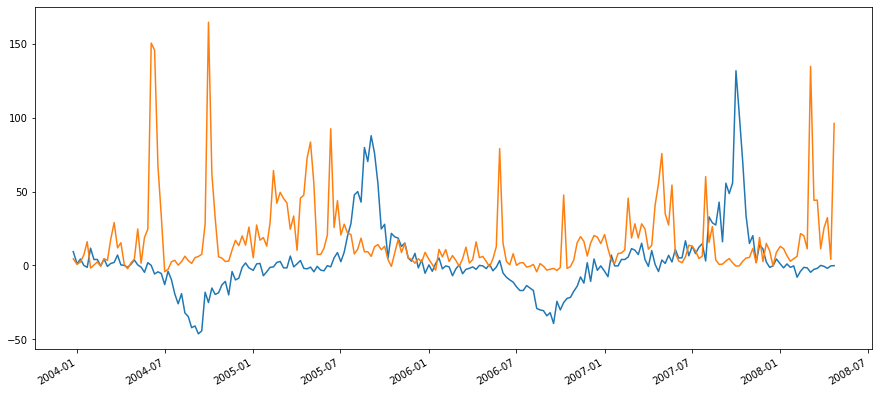

In [113]:
# y_pred = y_pred + test_seas_model
y_test.plot()
y_pred.plot()
# test_seas_model.plot()

In [114]:
model_classification(y_test, y_pred)

--------------------
RMSE: 38.08
--------------------
MAE: 25.25
Explained variance: -1.419
--------------------


## Regression (Linear Regression)

In [71]:
from sklearn.linear_model import LinearRegression

In [102]:
X_train = (
    sj_train_train_wo_seas
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases_wo_seas'], axis=1)
)
X_test = (
    sj_train_test_wo_seas
    .drop(['week_start_date',
           'city',
           'year',
           'weekofyear',
           'month',
           'total_cases_wo_seas'], axis=1)
)
y_train = sj_train_train_tc_wo_seas.total_cases_wo_seas
y_test = sj_train_test_tc_wo_seas.total_cases_wo_seas

In [103]:
lr = LinearRegression()

In [104]:
lr.fit(X_train, y_train)

LinearRegression()

In [105]:
y_pred = lr.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

In [99]:
test_seas_model = seasonality_for_test(sj_train_test, sj_train_train_seas)
test_seas_model.index = y_test.index 
# test_seas_model

<AxesSubplot:>

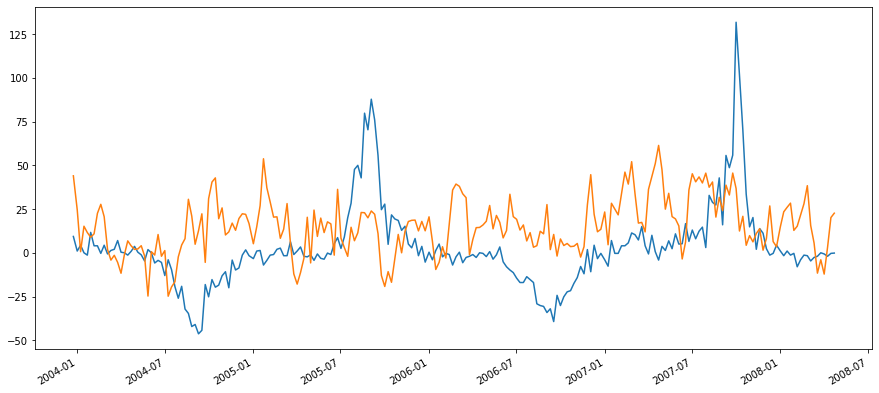

In [107]:
# y_pred = y_pred + test_seas_model
y_test.plot()
y_pred.plot()
# test_seas_model.plot()

In [101]:
model_classification(y_test, y_pred)

--------------------
RMSE: 34.78
--------------------
MAE: 29.29
Explained variance: -0.078
--------------------
